In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import os

from sklearn.metrics import classification_report
import tensorflow.keras.backend as K
from tensorflow.keras import layers

In [ ]:
# Config
INPUT_DIR = Path("./output_wav2vec_precomputed_features")
OUTPUT_DIR = Path("./output_conformer_training_tpu")
OUTPUT_DIR.mkdir(exist_ok=True)

MAX_SEQ_LEN = 150
EMBEDDING_DIM = 768
LABEL_COLS = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection', 'NoStutter']
NUM_CLASSES = len(LABEL_COLS)

BATCH_SIZE_PER_REPLICA = 16
EPOCHS = 50
# a lower learning rate for stability with complex models
LEARNING_RATE = 1e-5
THRESHOLD = 0.5

TRAIN_DATA_PATH = INPUT_DIR / "train_data.npz"
VAL_DATA_PATH = INPUT_DIR / "val_data.npz"
TEST_DATA_PATH = INPUT_DIR / "test_data.npz"
BEST_MODEL_PATH = OUTPUT_DIR / "best_conformer_model_tpu.keras"

In [ ]:
print("--- Initializing TPU Strategy ---")

try:
    # This is the robust, user-provided method for Kaggle TPU initialization
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)

    print('✅ TPU successfully initialized. Found TPU: ', tpu.master())
    # Global batch size is per-replica batch size * number of replicas
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
    print(f"Global batch size set to: {BATCH_SIZE}")
    print("Number of replicas:", strategy.num_replicas_in_sync)

except Exception as e:
    print(f"⚠️ TPU initialization failed, this is the error: {e}")
    print("Falling back to default strategy (CPU/GPU).")
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA

--- Initializing TPU Strategy ---
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1753095378.258260      10 service.cc:148] XLA service 0x56d70b019050 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753095378.258305      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1753095378.258310      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1753095378.258312      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1753095378.258315      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1753095378.258317      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1753095378.258320      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1753095378.258322      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1753095378.258325      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [ ]:
print("\n--- Loading all compressed features into RAM... ---")

# Load the compressed .npz files directly into memory
train_data = np.load(TRAIN_DATA_PATH)
val_data = np.load(VAL_DATA_PATH)
test_data = np.load(TEST_DATA_PATH)

# Access the arrays by the keys we used when saving ('x' and 'y')
X_train, y_train = train_data['x'], train_data['y']
X_val, y_val = val_data['x'], val_data['y']
X_test, y_test = test_data['x'], test_data['y']

print("All compressed data loaded successfully.")
print(f"X_train shape: {X_train.shape}")


--- Loading all compressed features into RAM... ---
All compressed data loaded successfully.
X_train shape: (30778, 150, 768)


In [ ]:
print("\n--- Building tf.data pipeline from in-memory arrays... ---")

def prepare_dataset(X, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=2048)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = prepare_dataset(X_train, y_train, shuffle=True)
val_dataset = prepare_dataset(X_val, y_val)
test_dataset = prepare_dataset(X_test, y_test)
print("Datasets created successfully.")


--- Building tf.data pipeline from in-memory arrays... ---
Datasets created successfully.


In [ ]:
with strategy.scope():
    print("\n--- Building Conformer Model inside TPU Strategy Scope... ---")

    # --- Conformer Block Implementation ---
    def conformer_block(x, num_heads=4, ff_dim=128, dropout=0.1):
        # Convolution Module
        x_conv = layers.LayerNormalization()(x)
        x_conv = layers.Conv1D(filters=EMBEDDING_DIM * 2, kernel_size=1, activation="relu")(x_conv)
        x_conv = layers.DepthwiseConv1D(kernel_size=3, padding="same")(x_conv)
        x_conv = layers.BatchNormalization()(x_conv)
        x_conv = layers.Activation("swish")(x_conv)
        x_conv = layers.Conv1D(filters=EMBEDDING_DIM, kernel_size=1)(x_conv)
        x_conv = layers.Dropout(dropout)(x_conv)
        x = x + x_conv # Residual connection

        # Attention Module
        x_attn = layers.LayerNormalization()(x)
        x_attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=EMBEDDING_DIM // num_heads)(x_attn, x_attn)
        x_attn = layers.Dropout(dropout)(x_attn)
        x = x + x_attn # Residual connection

        # Feed Forward Module
        x_ff = layers.LayerNormalization()(x)
        x_ff = layers.Dense(ff_dim, activation="swish")(x_ff)
        x_ff = layers.Dropout(dropout)(x_ff)
        x_ff = layers.Dense(EMBEDDING_DIM)(x_ff)
        x = x + x_ff # Residual connection

        return x

    def build_conformer_classifier(input_shape, num_classes):
        inputs = layers.Input(shape=input_shape)
        x = inputs

        # Apply one or more Conformer blocks
        x = conformer_block(x, num_heads=4, ff_dim=256)
        x = conformer_block(x, num_heads=4, ff_dim=256)

        # Pool the sequence to a single vector
        x = layers.GlobalAveragePooling1D()(x)

        # Classifier head
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(num_classes, activation='sigmoid')(x)

        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)
        
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc', multi_label=True)]
        )
        return model

    model = build_conformer_classifier(input_shape=(MAX_SEQ_LEN, EMBEDDING_DIM), num_classes=NUM_CLASSES)

model.summary()

checkpoint = tf.keras.callbacks.ModelCheckpoint(BEST_MODEL_PATH, monitor='val_auc', mode='max', save_best_only=True, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True)


--- Building Conformer Model inside TPU Strategy Scope... ---


I0000 00:00:1753095514.341014      10 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 150, 768)  │      1,536 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 150, 1536) │  1,181,184 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv1d    │ (None, 150, 1536) │      6,144 │ conv1d[0][0]      │
│ (DepthwiseConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 150, 1536) │      6,144 │ depthwise_conv1d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 150, 1536) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 150, 768)  │  1,180,416 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 150, 768)  │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 150, 768)  │          0 │ input_layer[0][0… │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 150, 768)  │  2,362,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 150, 768)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 150, 768)  │          0 │ add[0][0],        │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 150, 256)  │    196,864 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 150, 256)  │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 150, 768)  │    197,376 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 150, 768)  │          0 │ add_1[0][0],      │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 10,369,414 (39.56 MB)

 Trainable params: 10,363,270 (39.53 MB)

 Non-trainable params: 6,144 (24.00 KB)

In [13]:
print("\n--- Starting Training on TPU... ---")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint, early_stopping]
)


--- Starting Training on TPU... ---
Epoch 1/50


I0000 00:00:1753095567.325796      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:875898432909116477
I0000 00:00:1753095569.060991     961 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(15466465124949308232), session_name()
I0000 00:00:1753095586.622439     961 tpu_compile_op_common.cc:245] Compilation of 15466465124949308232 with session name  took 17.561350264s and succeeded
I0000 00:00:1753095586.687195     961 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(15466465124949308232), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_875898432909116477", property.function_library_fingerprint = 5727436575829571021, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z

239/241 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2370 - auc: 0.5822 - loss: 0.6001 - precision: 0.4364 - recall: 0.1790

I0000 00:00:1753095597.463094     952 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(9200060098412951180), session_name()
I0000 00:00:1753095614.410998     952 tpu_compile_op_common.cc:245] Compilation of 9200060098412951180 with session name  took 16.947822815s and succeeded
I0000 00:00:1753095614.461939     952 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(9200060098412951180), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_875898432909116477", property.function_library_fingerprint = 5727436575829571021, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "8,150,768,;8,6,;", property.guaranteed_constants_size = 0, embedding_parti

241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.2371 - auc: 0.5827 - loss: 0.5999 - precision: 0.4370 - recall: 0.1791

I0000 00:00:1753095631.650052      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:8714271137872365585
I0000 00:00:1753095632.132137     917 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(3778433549465053947), session_name()
I0000 00:00:1753095633.863458     917 tpu_compile_op_common.cc:245] Compilation of 3778433549465053947 with session name  took 1.731181476s and succeeded
I0000 00:00:1753095633.870800     917 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(3778433549465053947), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_8714271137872365585", property.function_library_fingerprint = 13249024532786548839, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z 


Epoch 1: val_auc improved from -inf to 0.65288, saving model to output_conformer_training_tpu/best_conformer_model_tpu.keras
241/241 ━━━━━━━━━━━━━━━━━━━━ 89s 214ms/step - accuracy: 0.2371 - auc: 0.5828 - loss: 0.5999 - precision: 0.4372 - recall: 0.1791 - val_accuracy: 0.2916 - val_auc: 0.6529 - val_loss: 0.5767 - val_precision: 0.4695 - val_recall: 0.2638
Epoch 2/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2832 - auc: 0.6858 - loss: 0.5449 - precision: 0.5558 - recall: 0.2434
Epoch 2: val_auc improved from 0.65288 to 0.70831, saving model to output_conformer_training_tpu/best_conformer_model_tpu.keras
241/241 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.2832 - auc: 0.6859 - loss: 0.5449 - precision: 0.5559 - recall: 0.2435 - val_accuracy: 0.3025 - val_auc: 0.7083 - val_loss: 0.5593 - val_precision: 0.5282 - val_recall: 0.3763
Epoch 3/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3102 - auc: 0.7032 - loss: 0.5347 - precision: 0.5652 - recall: 0.2809
Ep


--- Evaluating Model on the Test Set ---


I0000 00:00:1753096345.304689      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:14150787917538882525
E0000 00:00:1753096345.344529      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/batch_normalization_1/Cast/ReadVariableOp.
I0000 00:00:1753096345.448904     975 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(13002451267633787879), session_name()
I0000 00:00:1753096346.860167     975 tpu_compile_op_common.cc:245] Compilation of 13002451267633787879 with session name  took 1.41120711s and succeeded
I0000 00:00:1753096346.863798     975 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(13002451267633787879), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_14150787917538882525", property.function_library_fingerprint = 5860086238597181137, property.mlir_modul

67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step

I0000 00:00:1753096353.155634      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:4635084862076183474
I0000 00:00:1753096353.439885     955 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(10519654301157118725), session_name()
I0000 00:00:1753096355.600139     955 tpu_compile_op_common.cc:245] Compilation of 10519654301157118725 with session name  took 2.160192768s and succeeded
I0000 00:00:1753096355.605365     955 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(10519654301157118725), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_4635084862076183474", property.function_library_fingerprint = 13423869306841362055, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, top

68/68 ━━━━━━━━━━━━━━━━━━━━ 19s 192ms/step

--- Classification Report (Multi-Label) ---
              precision    recall  f1-score   support

Prolongation       0.80      0.21      0.33      2613
       Block       0.60      0.29      0.39      3501
    SoundRep       0.65      0.26      0.38      1891
     WordRep       0.52      0.39      0.44      1742
Interjection       0.87      0.57      0.69      3344
   NoStutter       0.49      0.58      0.53      1674

   micro avg       0.65      0.38      0.48     14765
   macro avg       0.66      0.38      0.46     14765
weighted avg       0.68      0.38      0.47     14765
 samples avg       0.46      0.39      0.40     14765


--- Generating plots for model training history... ---


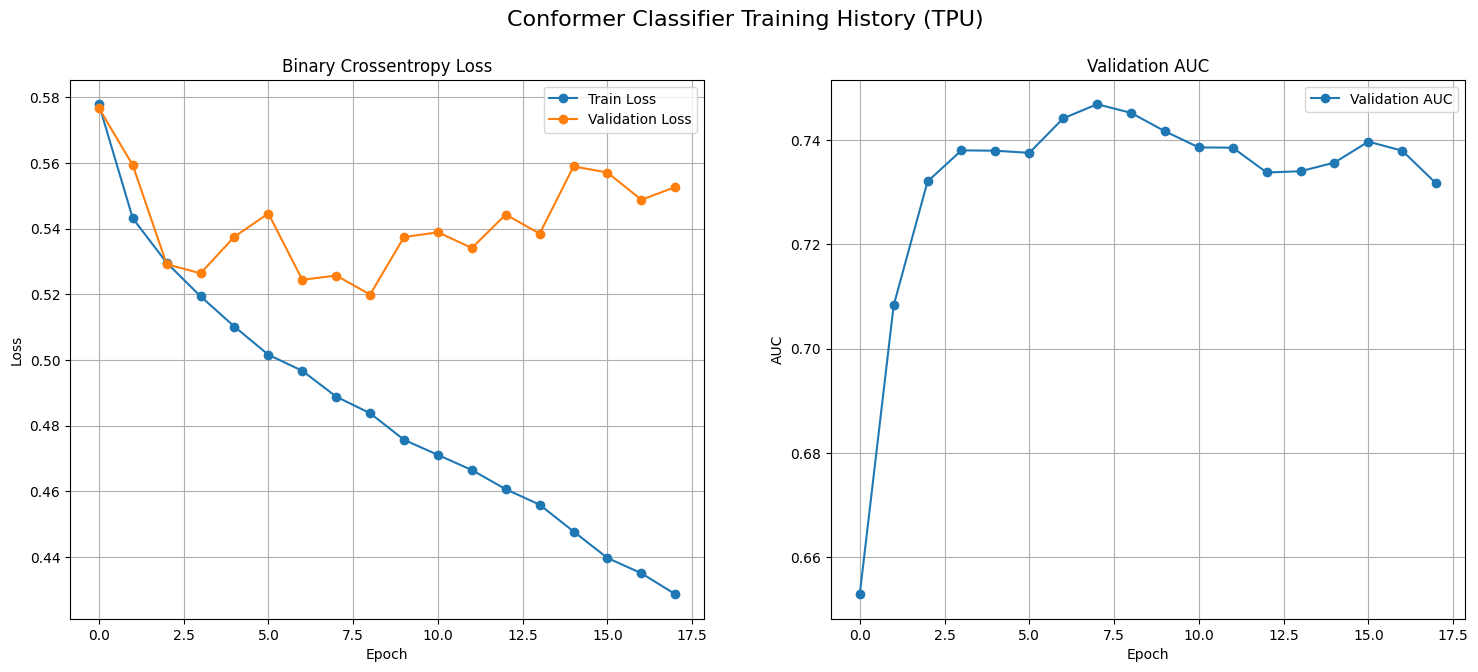


--- Pipeline complete. All outputs saved in 'output_conformer_training_tpu' directory. ---


In [14]:
print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred)
report = classification_report(y_test[:num_predictions], y_pred, target_names=LABEL_COLS, zero_division=0)
print("\n--- Classification Report (Multi-Label) ---")
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

# --- Plotting History ---
print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Conformer Classifier Training History (TPU)', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history_conformer_tpu.png")
plt.show()

print(f"\n--- Pipeline complete. All outputs saved in '{OUTPUT_DIR}' directory. ---")